Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
class Feature_parameter:
    def __init__(self):
        self.cspace = ['HSV', 'HLS', 'YUV', 'LUV', 'RGB','YCrCb']
        self.color_space = self.cspace[4]
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.orient = 9
        self.pix_per_cell =8
        self.cell_per_block = 2
        self.hog_channel=0
        self.spatial_feat=True
        self.hist_feat=True
        self.hog_feat=True

In [21]:
class SVM_classifier:
    def __init__(self):
        self.model = None
        self.scaler = None

In [8]:
feat_params = Feature_parameter()

# Histogram of Oriented Gradients (HOG)
## 1. Explain how (and identify where in your code) you extracted HOG features from the training images.
#### The code for this step is contained in the function below : get_hog_features

#### I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, feat_params,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=feat_params.orient, 
                                  pixels_per_cell=(feat_params.pix_per_cell, feat_params.pix_per_cell),
                                  cells_per_block=(feat_params.cell_per_block, feat_params.cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=feat_params.orient, 
                       pixels_per_cell=(feat_params.pix_per_cell, feat_params.pix_per_cell),
                       cells_per_block=(feat_params.cell_per_block, feat_params.cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [10]:
def read_images(img_paths):
    images = []
    for path in img_paths:
        images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    return images

In [11]:
vehicle_paths = glob.glob('vehicles/vehicles/**/*.png')
non_vehicles_paths = glob.glob('non-vehicles/non-vehicles/**/*.png')
print ("Number of vehicle images = %d" %len(vehicle_paths))
print ("Number of non-vehicle images = %d" %len(non_vehicles_paths))

Number of vehicle images = 8792
Number of non-vehicle images = 8968


In [12]:
vehicle_imgs = read_images(vehicle_paths)
non_vehicle_imgs = read_images(non_vehicles_paths)

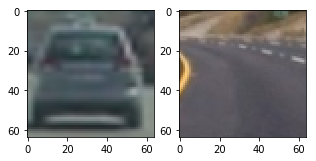

In [13]:
fig, (car, no_car) = plt.subplots(1, 2, figsize=(5,5))
car.imshow(vehicle_imgs[4])
no_car.imshow(non_vehicle_imgs[4])

In [14]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [15]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [47]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, feat_params):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        if feat_params.color_space != 'RGB':
            if feat_params.color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif feat_params.color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif feat_params.color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif feat_params.color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif feat_params.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if feat_params.spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=feat_params.spatial_size)
            file_features.append(spatial_features)
        if feat_params.hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=feat_params.hist_bins)
            file_features.append(hist_features)
        if feat_params.hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if feat_params.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    feat_params, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,feat_params.hog_channel], feat_params, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [52]:
def get_basic_feat():
    feat_params = Feature_parameter()
    feat_params.color_space = "RGB"
    feat_params.orient = 9
    feat_params.pix_per_cell = 8
    feat_params.cell_per_block = 2
    feat_params.spatial_size = (16, 16)
    feat_params.hist_bins = 16
    feat_params.spatial_feat = True
    feat_params.hist_feat = True
    feat_params.hog_feat = True
    feat_params.hog_channel = 'ALL'
    return feat_params

In [53]:
def extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, feat_params):
    car_features = extract_features(vehicle_imgs, feat_params)
    notcar_features = extract_features(non_vehicle_imgs, feat_params)
    return car_features, notcar_features

In [54]:
basic_feat_params = get_basic_feat()
basic_feat_params.spatial_feat = False
basic_feat_params.hist_feat = False

# Now extract hog features on training data
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.

#### Here is an example using the YCrCb color space and HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):



In [38]:
def get_hog_channelwise(img, feat_params, main_title):
    output = []
    titles = []
    output.append(img)
    titles.append(main_title)
    if feat_params.color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif feat_params.color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif feat_params.color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif feat_params.color_space == 'HSV':
        feature_image =  cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    else:
        feature_image = np.copy(img)
    for channel in range(3):
        title = main_title + "_" + feat_params.color_space +"_channel_" + str(channel)
        features, hog_img = get_hog_features(feature_image[:,:,channel], feat_params, 
                             vis=True, feature_vec=True)

        output.append(hog_img)
        titles.append(title)
    return output, titles

In [39]:
def plot_img_hogs(hog_imgs, titles):
    fig, (img1, img2, img3, img4) = plt.subplots(1,4, figsize=(20,20))
    img1.imshow(hog_imgs[0], 'gray')
    img1.set_title(titles[0])
    img2.imshow(hog_imgs[1], 'gray')
    img2.set_title(titles[1])
    img3.imshow(hog_imgs[2], 'gray')
    img3.set_title(titles[2])
    img4.imshow(hog_imgs[3], 'gray')
    img4.set_title(titles[3])

In [40]:
def testing_with_diff_colorspace(sample_vehicles, sample_nonvehicles, colorspaces):
    feat_params = get_basic_feat()
    for color_space in colorspaces:
        feat_params.color_space = color_space
        
        for car_img in sample_vehicles:
            hog_imgs, titles = get_hog_channelwise(car_img, feat_params, 'Car')
            plot_img_hogs(hog_imgs, titles)
            
        for notcar_img in sample_nonvehicles:
            hog_imgs, titles = get_hog_channelwise(notcar_img, feat_params, 'Non-car')
            plot_img_hogs(hog_imgs, titles)

#### I then tried to visualize the hog features in all channels for different color spaces. The idea is to run the svm classifier on different color spaces and see which one gives better accuracy.

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


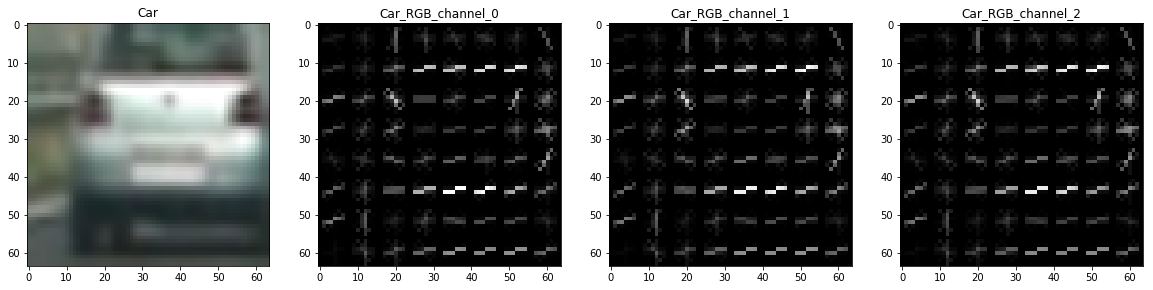

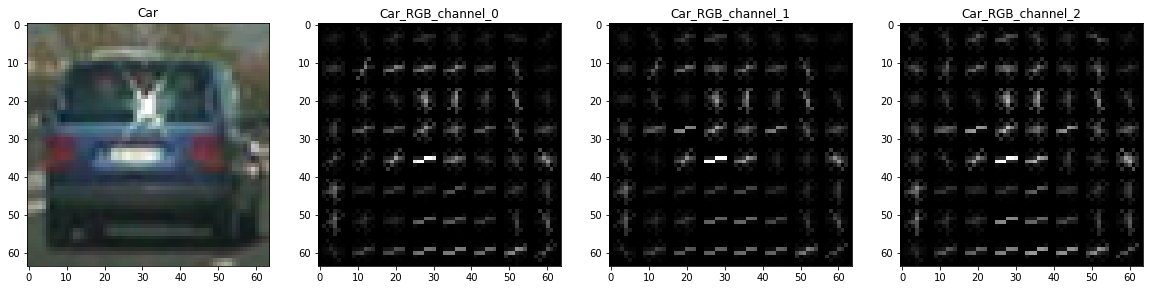

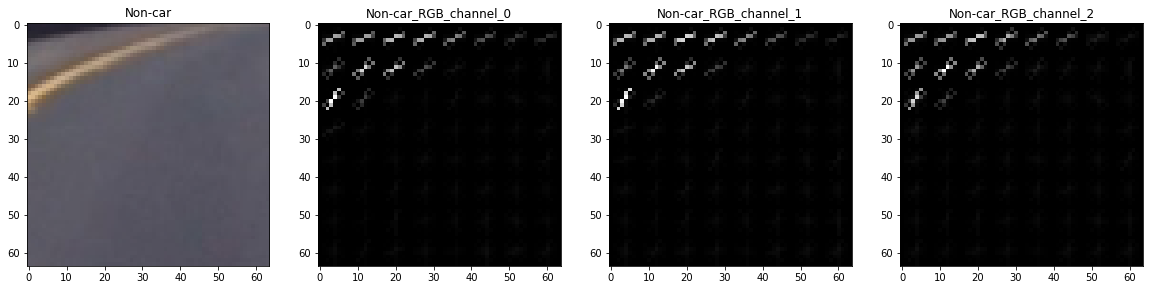

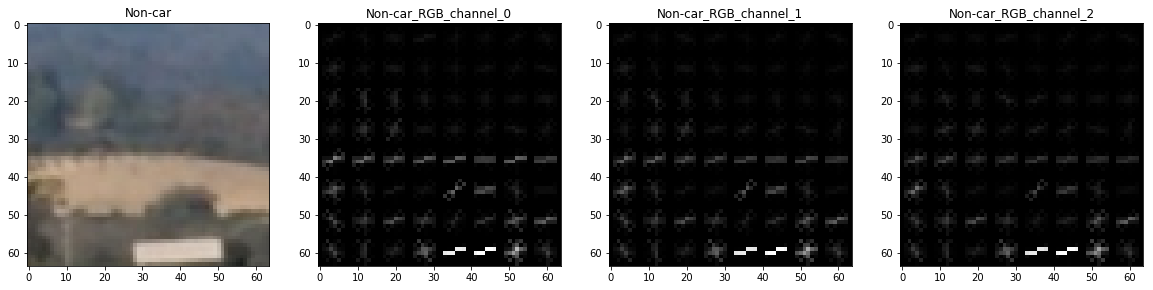

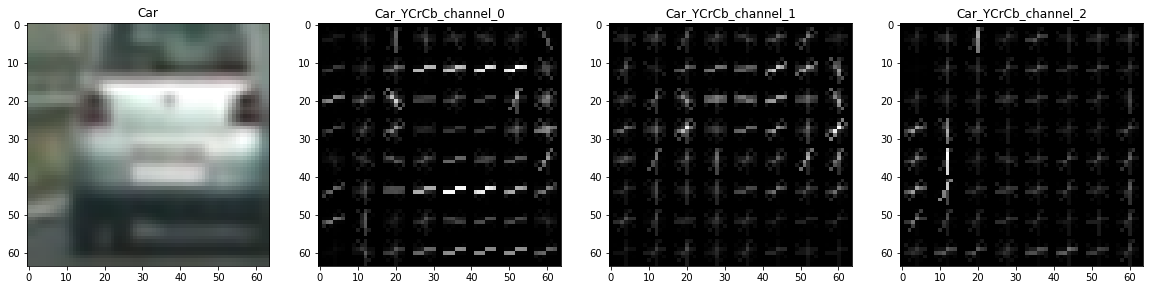

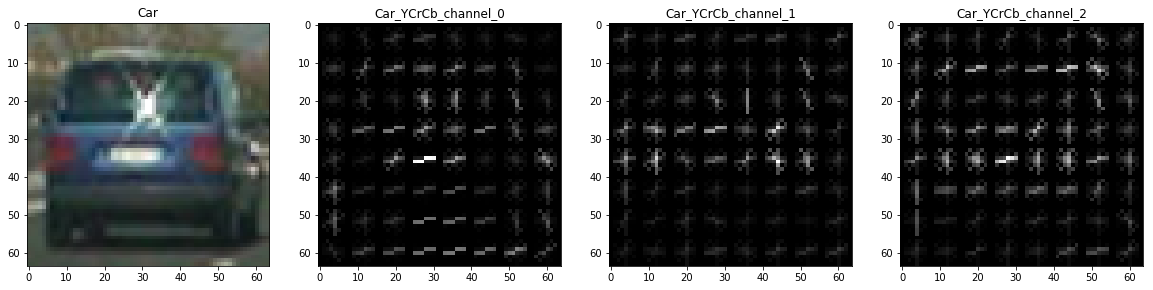

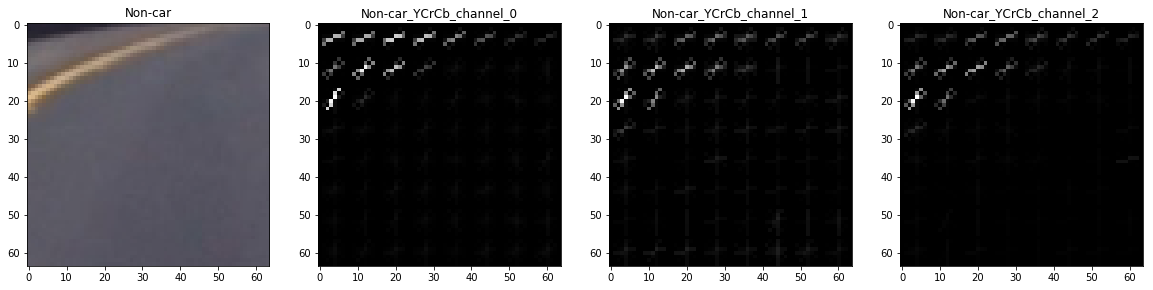

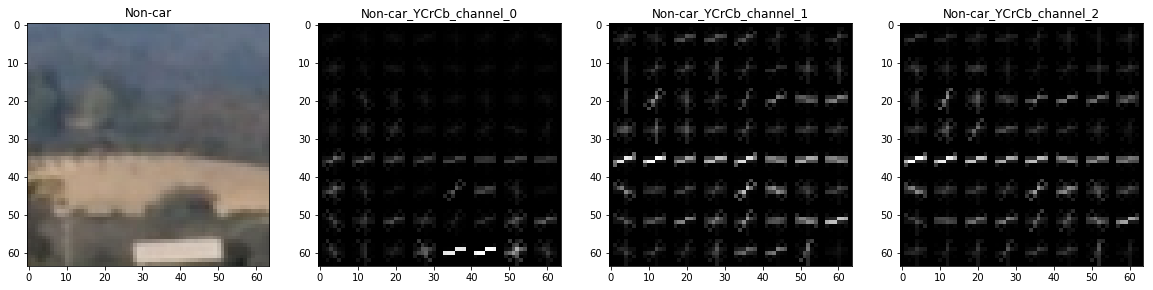

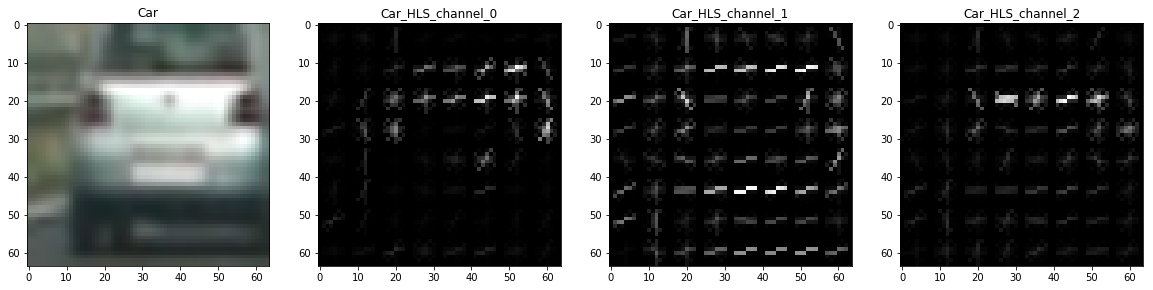

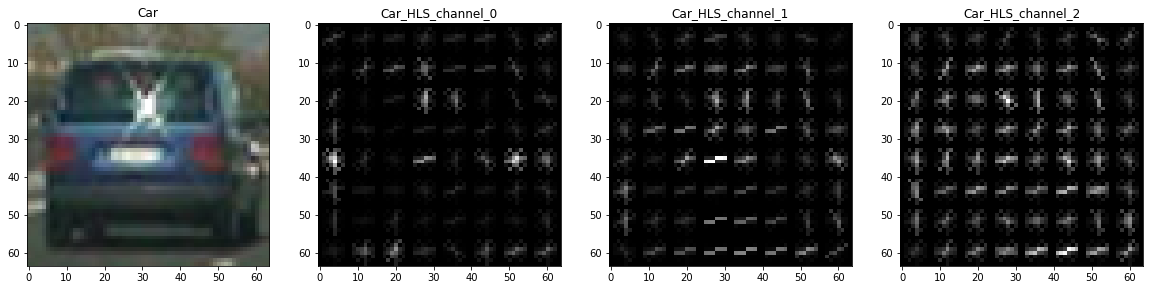

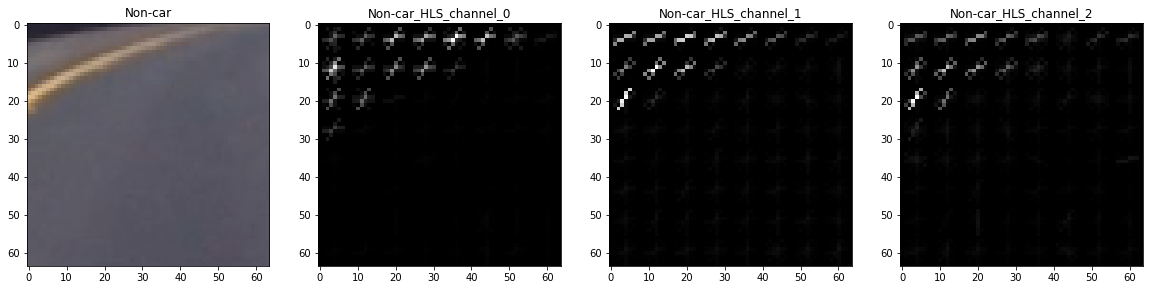

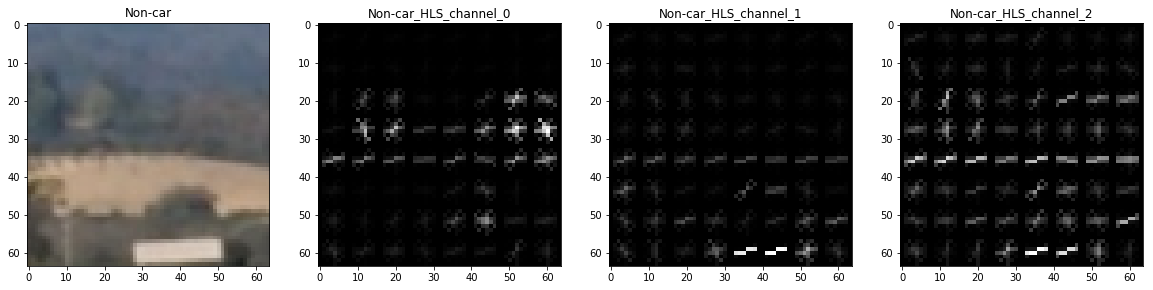

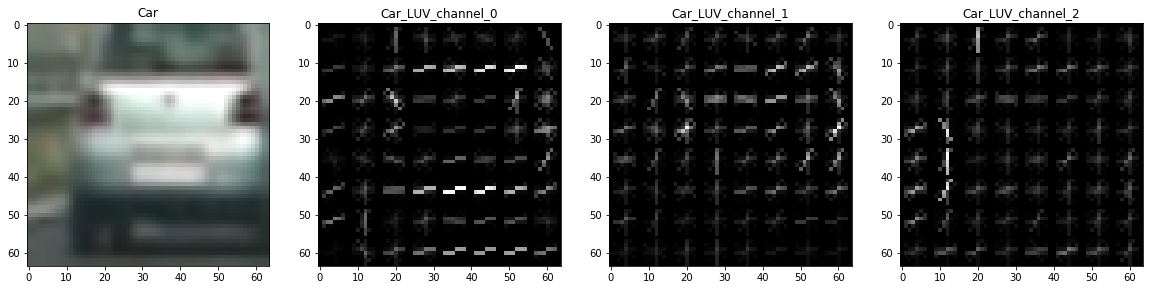

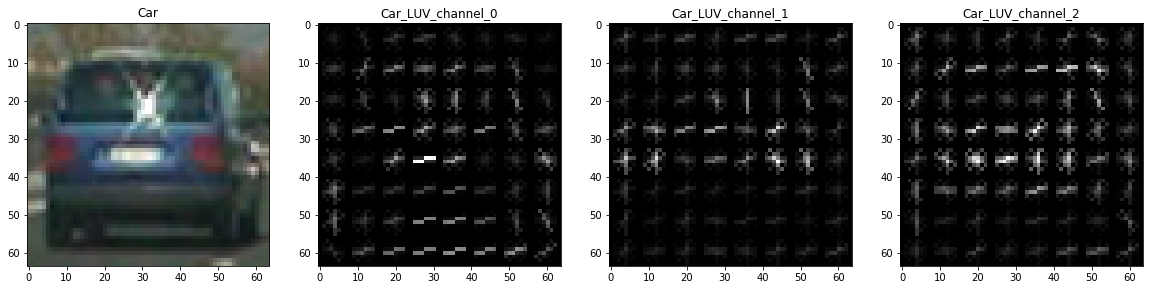

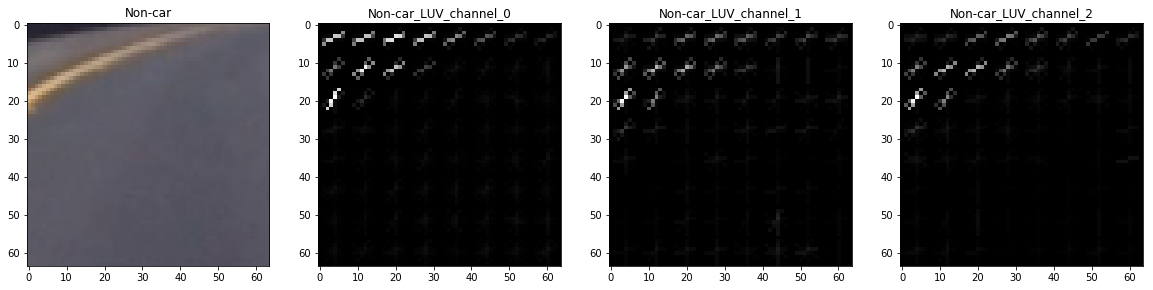

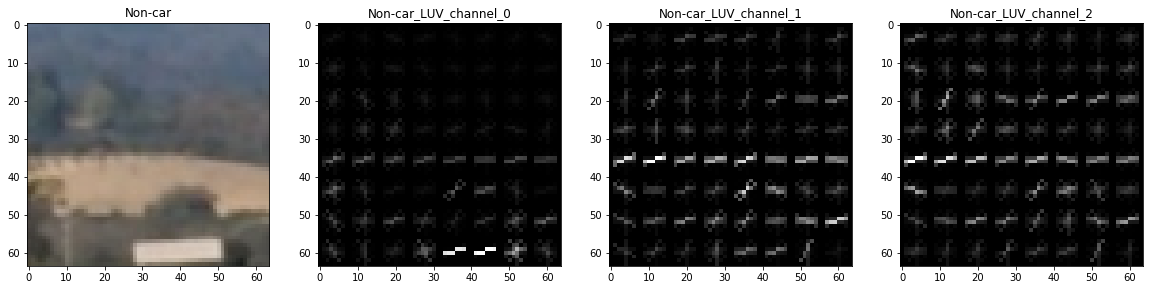

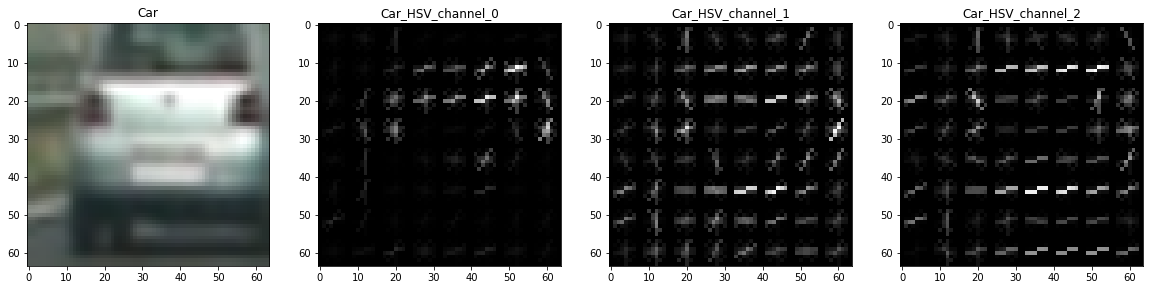

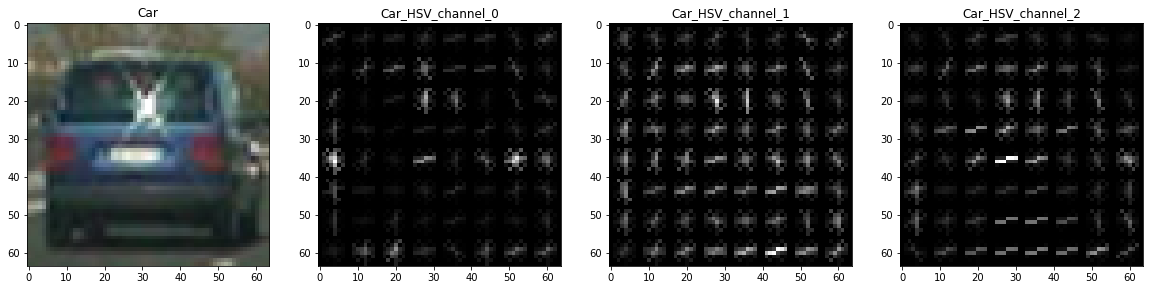

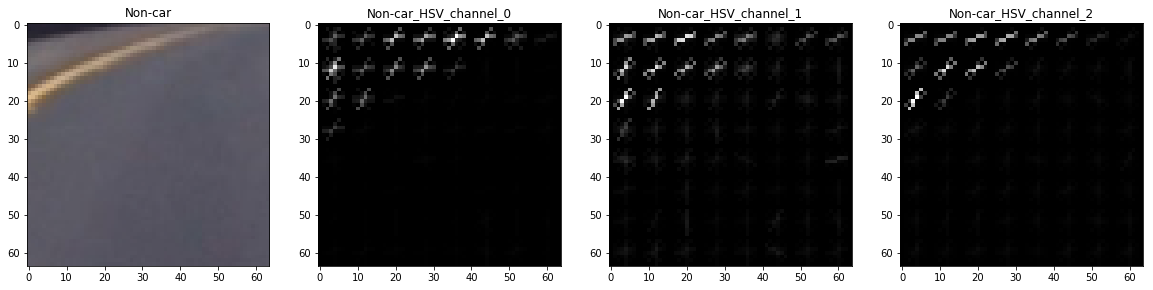

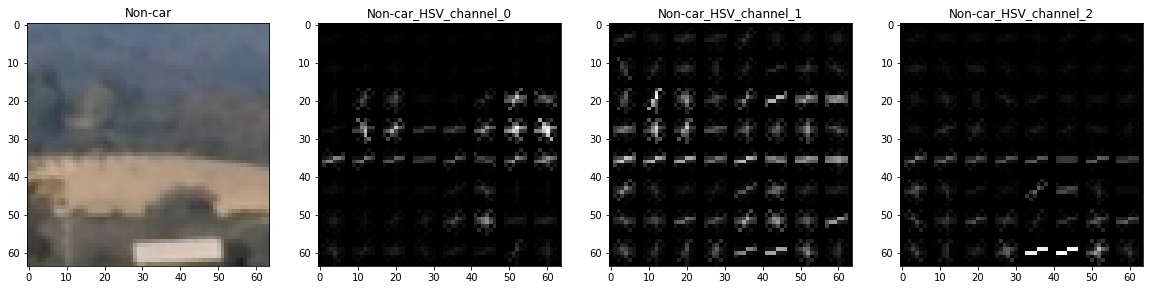

In [41]:
# 2 sample images from both car and not car.
sample_vehicles = [vehicle_imgs[100], vehicle_imgs[200]]
sample_nonvehicles = [non_vehicle_imgs[100], non_vehicle_imgs[200]]

testing_with_diff_colorspace(sample_vehicles, sample_nonvehicles, colorspaces=['RGB','YCrCb','HLS','LUV','HSV'])

## 2. Explain how you settled on your final choice of HOG parameters.
#### I tried various combinations of parameters and colorspaces as shown above and ran svm classifier. The feature parameters resulting into higher accuracy is chosen as the best params for HOG features.

## 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
#### I trained a linear SVM using 80% of training data and validated on 20%  of training data.

In [43]:
def svm_classifier(car_features, notcar_features, feat_params):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',feat_params.orient,'orientations',feat_params.pix_per_cell,
        'pixels per cell and', feat_params.cell_per_block,'cells per block', 'and color space:', feat_params.color_space)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    svm_output = SVM_classifier()
    svm_output.model = svc
    svm_output.scaler = X_scaler
    return svm_output


In [44]:
basic_feat_params = get_basic_feat()
basic_feat_params.spatial_feat = False
basic_feat_params.hist_feat = False

In [55]:
# Now extract hog features on training data
basic_feat_params.color_space = 'RGB'
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: RGB
Feature vector length: 5292
23.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9665


In [56]:
# Now extract hog features on training data
basic_feat_params.color_space = 'YCrCb'
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: YCrCb
Feature vector length: 5292
14.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9879


In [57]:
# Now extract hog features on training data
basic_feat_params.color_space = 'HLS'
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: HLS
Feature vector length: 5292
15.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9854


In [58]:
# Now extract hog features on training data
basic_feat_params.color_space = 'HSV'
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: HSV
Feature vector length: 5292
15.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


In [59]:
# Now extract hog features on training data
basic_feat_params.color_space = 'YUV'
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: YUV
Feature vector length: 5292
4.85 Seconds to train SVC...
Test Accuracy of SVC =  0.987


### After evaluating SVM classifier accuracy on different color space and most appropriate pixels per cell and cells per block, the final parameters are chosen.

Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: YCrCb
As well as adding hist_features and spatial features. My svm classifier was able to accuracy of 99.4% 
- Feature vector length: 8412
- 11.72 Seconds to train SVC...
- Test Accuracy of SVC =  0.9944

In [93]:
# Now extract hog features on training data
basic_feat_params.color_space = 'YCrCb'
basic_feat_params.spatial_feat = True
basic_feat_params.hist_feat = True
basic_feat_params.spatial_size = (32, 32)
basic_feat_params.hist_bins = 32
car_features_hog, notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, basic_feat_params)
svm_output = svm_classifier(car_features_hog, notcar_features_hog, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: YCrCb
Feature vector length: 8460
6.26 Seconds to train SVC...
Test Accuracy of SVC =  0.993


# Sliding Window Search




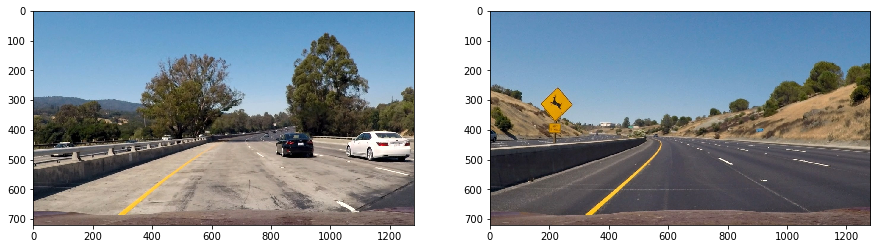

In [61]:
car_img_test = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
notcar_img_test = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
fig, (car, no_car) = plt.subplots(1, 2, figsize=(15,15))
car.imshow(car_img_test)
no_car.imshow(notcar_img_test)

## 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
#### I decided to search random window positions, different y_start and y_stop at random scales ranging from 1.0, 1.5, 2.0, 2.5 all over the image as follows:

In [84]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [64]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [69]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, feat_params):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if feat_params.color_space != 'RGB':
        if feat_params.color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif feat_params.color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif feat_params.color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif feat_params.color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif feat_params.color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if feat_params.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=feat_params.spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if feat_params.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=feat_params.hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if feat_params.hog_feat == True:
        if feat_params.hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    feat_params, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,feat_params.hog_channel], feat_params, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [70]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svm_params, feat_params):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, feat_params)
        #5) Scale extracted features to be fed to classifier
        test_features = svm_params.scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svm_params.model.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


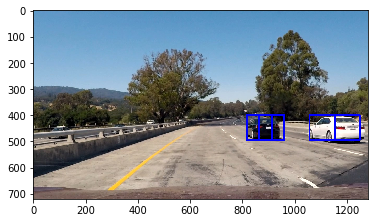

In [94]:
windows = slide_window(car_img_test, x_start_stop=[None, None], y_start_stop=[400, 656], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(car_img_test, windows, svm_output, basic_feat_params)                       

window_img = draw_boxes(car_img_test, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [102]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [150]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svm_params, feat_params, jpgFlag=False):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // feat_params.pix_per_cell) - feat_params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // feat_params.pix_per_cell) - feat_params.cell_per_block + 1 
    nfeat_per_block = feat_params.orient*feat_params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // feat_params.pix_per_cell) - feat_params.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feat_params, feature_vec=False)
    hog2 = get_hog_features(ch2, feat_params, feature_vec=False)
    hog3 = get_hog_features(ch3, feat_params, feature_vec=False)
    
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*feat_params.pix_per_cell
            ytop = ypos*feat_params.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = []
            hist_features = []
            if feat_params.spatial_feat:
                spatial_features = bin_spatial(subimg, size=feat_params.spatial_size)
            if feat_params.hist_feat:
                hist_features = color_hist(subimg, nbins=feat_params.hist_bins)

            comb_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = svm_params.scaler.transform(comb_features)       
            test_prediction = svm_params.model.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction == 1:
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows


c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


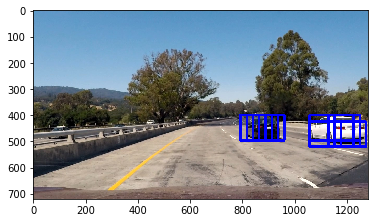

In [106]:
ystart = 400
ystop = 656
scale=1.5
car_windows = find_cars(car_img_test, ystart, ystop, scale, svm_output, basic_feat_params)
out_img = draw_boxes(car_img_test, car_windows, color=(0,0,255), thick=8)
plt.imshow(out_img)

## 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?
#### Ultimately I searched on four scales [1.0,  1.5, 2.0, 2.5] using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result. Here are some example images:

In [107]:
def windows_search_single_image(img, svm_param, feat_param):
        
    car_windows = []
    car_windows_1 = find_cars(img, 392, 520, 1.0, svm_param, feat_param)
    car_windows_2 = find_cars(img, 400, 520, 1.0, svm_param, feat_param) 
    car_windows_3 = find_cars(img, 400, 620, 1.0, svm_param, feat_param) 
    car_windows_4 = find_cars(img, 400, 656, 1.0, svm_param, feat_param) 
    car_windows_5 = find_cars(img, 400, 620, 1.5, svm_param, feat_param) 
    car_windows_6 = find_cars(img, 400, 700, 2.0, svm_param, feat_param) 
    car_windows_7 = find_cars(img, 392, 700, 2.0, svm_param, feat_param) 
    car_windows_8 = find_cars(img, 400, 700, 2.5, svm_param, feat_param) 
    
    car_windows.extend(car_windows_1)
    car_windows.extend(car_windows_2)
    car_windows.extend(car_windows_3)
    car_windows.extend(car_windows_4)
    car_windows.extend(car_windows_5)
    car_windows.extend(car_windows_6)
    car_windows.extend(car_windows_7)
    car_windows.extend(car_windows_8)
    
    return car_windows

In [109]:
def search_diff_windows_scale(imgs, svm_params, feat_params):
    out_imgs = []
    for img in imgs:
        boxes = windows_search_single_image(img, svm_params, feat_params)
        out_box_img = draw_boxes(img, boxes, color=(0,0,255), thick=8)
        out_imgs.append(out_box_img)
    return out_imgs

In [118]:
lane_imgs_file = glob.glob('test_images/test*.jpg')
lane_images = np.array(read_images(lane_imgs_file))
cars_boxes = search_diff_windows_scale(lane_images, svm_output, basic_feat_params)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


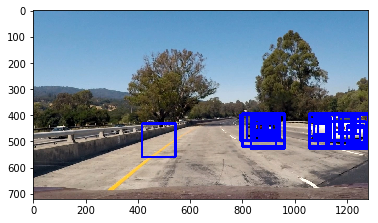

In [119]:
plt.imshow(cars_boxes[0])

In [120]:
def displayImage(imgs, x, y, figsize, titles):
    fig, axis = plt.subplots(x, y, figsize=figsize)
    img_count = len(imgs)
    k=0
    for i in range(x):
        for j in range(y):
            if k >= img_count:
                continue
            axis[i, j].imshow(imgs[k])
            axis[i, j].set_title(titles[k])
            k += 1

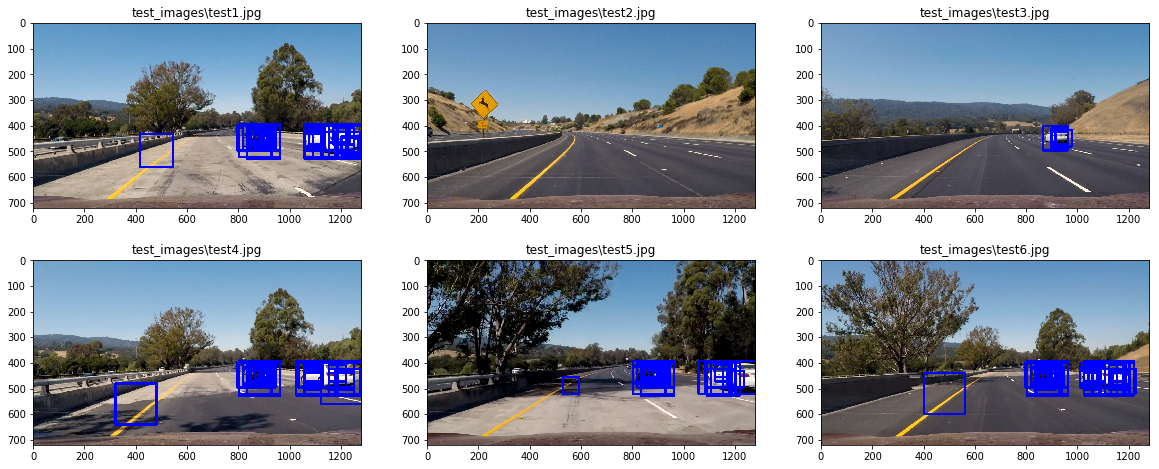

In [121]:
displayImage(cars_boxes, 2, 3, figsize=(20,8), titles=lane_imgs_file)

### After applying multiple scale and different windows, it helped in getting more true positives. Now by using heatmap, I removed the false positives.

In [125]:
from scipy.ndimage.measurements import label

In [115]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [116]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [124]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [127]:
def search_diff_windows_scale_single(img, svm_params, feat_params):
    boxes = windows_search_single_image(img, svm_params, feat_params)
    out_box_img = draw_boxes(img, boxes, color=(0,0,255), thick=8)
    return out_box_img, boxes

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


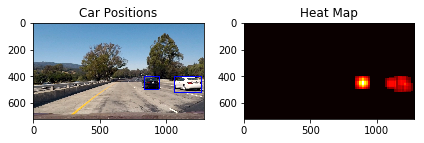

In [128]:
image = lane_images[0]
_, boxes = search_diff_windows_scale_single(image, svm_output, basic_feat_params)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## Video Implementation
### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

### Here's a link to my test-video result
### https://youtu.be/AKRjGGUDPYY

### Here's a link to my project-video result

### https://youtu.be/dNM_O4XAe5A


In [131]:
def pipeline_vehicle_detection(image, svm_params, feat_params):
    _, boxes = search_diff_windows_scale_single(image, svm_params, feat_params)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

In [136]:
# Draw hit map
heatmaps = []
detected_img = []
for img in lane_images:
    draw_img, heatmap = pipeline_vehicle_detection(img, svm_output, basic_feat_params)
    heatmaps.append(heatmap)
    detected_img.append(draw_img)

c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [137]:
def displayImage_hot(imgs, x, y, figsize, titles):
    fig, axis = plt.subplots(x, y, figsize=figsize)
    img_count = len(imgs)
    k=0
    for i in range(x):
        for j in range(y):
            if k >= img_count:
                continue
            axis[i, j].imshow(imgs[k], 'hot')
            axis[i, j].set_title(titles[k])
            k += 1

## 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.
#### I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

### Here's an example result showing the heatmap from a series of frames of video, the result of scipy.ndimage.measurements.label() and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

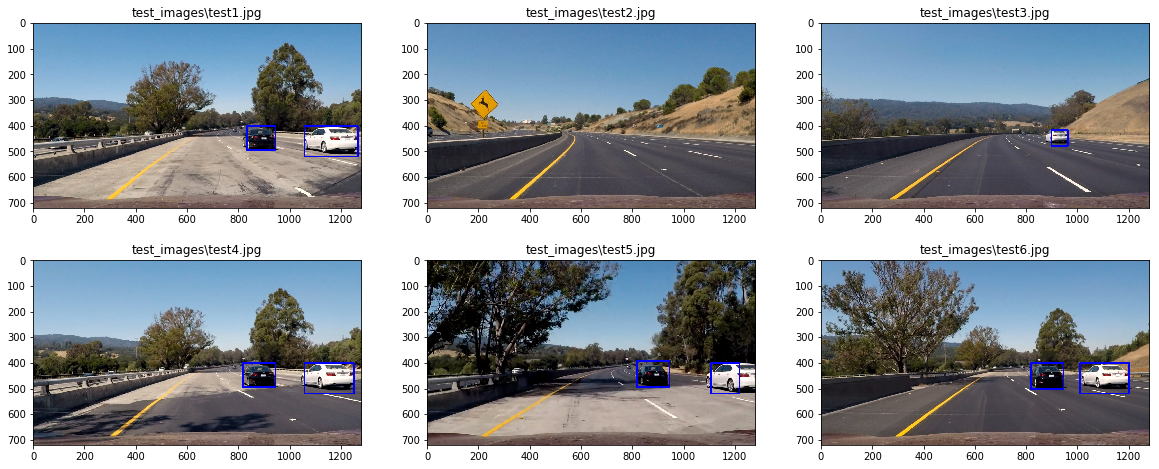

In [138]:
displayImage(detected_img, 2, 3, figsize=(20,8), titles=lane_imgs_file)

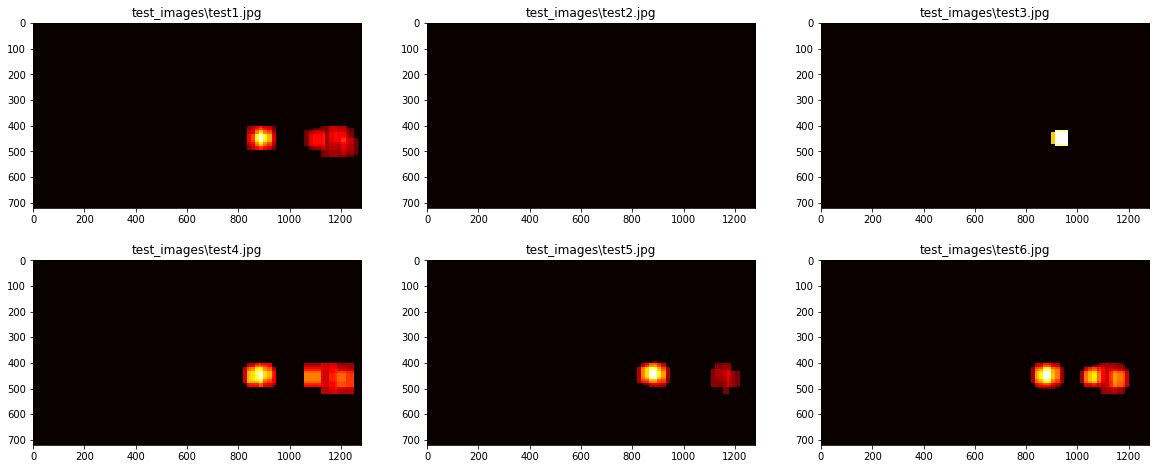

In [139]:
displayImage_hot(heatmaps, 2, 3, figsize=(20,8), titles=lane_imgs_file)

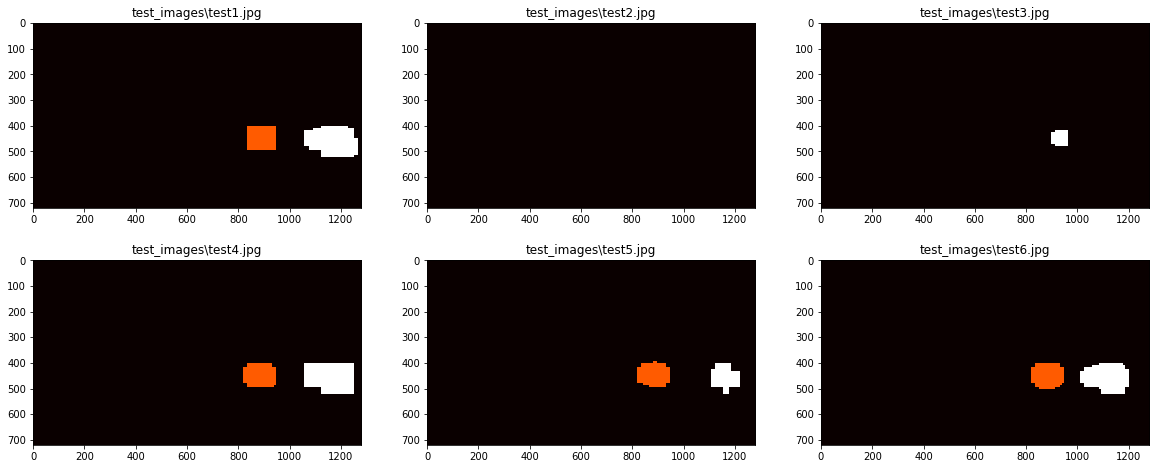

In [140]:
labels_heatmap = []
for heatmap in heatmaps:
    labels = label(heatmap)
    labels_heatmap.append(labels[0])
displayImage_hot(labels_heatmap, 2, 3, figsize=(20,8), titles=lane_imgs_file)

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

In [141]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [144]:
def process_image(image):
    failed_img = image
    output_img, heatmap_img = pipeline_vehicle_detection(image, svm_output, basic_feat_params)
    return output_img

In [145]:
white_output = 'test_video_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video test_video_final.mp4
[MoviePy] Writing video test_video_final.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]WARNING:py.warnings:c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [06:44<00:10, 10.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_final.mp4 

Wall time: 6min 45s


### I didn't used hist and spatial feature for final project video since it was detecting lot of time in detecting car in one frame. But its result was better than just cusing HoG. This can be seen in the test video.

In [147]:
modify_feat_param = get_basic_feat()
modify_feat_param.hist_feat = False
modify_feat_param.spatial_feat = False
modify_feat_param.color_space = 'YCrCb'
m_car_features_hog, m_notcar_features_hog = extract_features_car_notcar(vehicle_imgs, non_vehicle_imgs, modify_feat_param)
modify_svm_output = svm_classifier(m_car_features_hog, m_notcar_features_hog, modify_feat_param)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



Using: 9 orientations 8 pixels per cell and 2 cells per block and color space: YCrCb
Feature vector length: 5292
13.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


In [148]:
def m_process_image(image):
    failed_img = image
    output_img, heatmap_img = pipeline_vehicle_detection(image, modify_svm_output, modify_feat_param)
    return output_img

In [151]:
white_output = 'project_video_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(m_process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:c:\users\rajkuma\appdata\local\continuum\miniconda3\envs\tf35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:05:22<00:03,  3.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

Wall time: 1h 5min 23s


## Discussion
### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

### Challenges:
1. Finding the right scaling for the image was done manually. There could be better ways to select the right scaling based on the image.
2. I used the suggested orientation and pixel per cell values which proved to work well for the hog. Manually choosing this values based on the classifier accuracy might overfit the model. There should be better approach of choosing the right parameters to make the model more generalized. 
3. The classifier works well when using bin_spatial and hist features along with HoG. Alone HOG doesn't have very good results. 